Component orientations (from dataless seed downloaded on June 29, 2019)
BHU: az 135.1 dip -29.4
BHV: az 15.0  dip -29.2
BHW: az 255.0 dip -29.7

### Load, rotate, and plot data

#### Load in ZNE SAC files, rotate to RT and save. Only run once for each event (although multiple runs shouldn't give a problem).

(For deglitched data from DK)

In [4]:
import os
from obspy import read
from obspy.signal.rotate import rotate_ne_rt
import matplotlib.pyplot as plt

# === Parameters ===
# filedir = "H:\My Drive\Research\SharpSSPy"
filedir = "/Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/SharpSSPy"

evname = "S1000a"
dtype = "VEL"
pzfilter = True

datadir = os.path.join(filedir, "misc", evname)


In [ ]:

# === Load the 3 components ===
st_z = read(os.path.join(datadir, f"{evname}_{dtype}_BHZ.SAC"))[0]
st_n = read(os.path.join(datadir, f"{evname}_{dtype}_BHN.SAC"))[0]
st_e = read(os.path.join(datadir, f"{evname}_{dtype}_BHE.SAC"))[0]

# === BAZ ===
# S0976a: 101.8; S1000a: 34.2
baz = 34.2

# === Metadata checks ===
assert st_z.stats.delta == st_n.stats.delta == st_e.stats.delta, "Sampling rates differ"
assert len(st_z.data) == len(st_n.data) == len(st_e.data), "Trace lengths differ"

# === Rotate to RT ===
tr_r, tr_t = rotate_ne_rt(st_n.data, st_e.data, baz)

# === Create rotated traces ===
tr_r_obj = st_n.copy()
tr_t_obj = st_e.copy()
tr_r_obj.data = tr_r
tr_t_obj.data = tr_t
tr_r_obj.stats.channel = "BHR"
tr_t_obj.stats.channel = "BHT"

# === Save rotated components ===
output_dir = datadir  # Save in same directory
tr_r_obj.write(os.path.join(output_dir, f"{evname}_{dtype}_BHR.SAC"), format="SAC")
tr_t_obj.write(os.path.join(output_dir, f"{evname}_{dtype}_BHT.SAC"), format="SAC")

NameError: name 'tr_r' is not defined

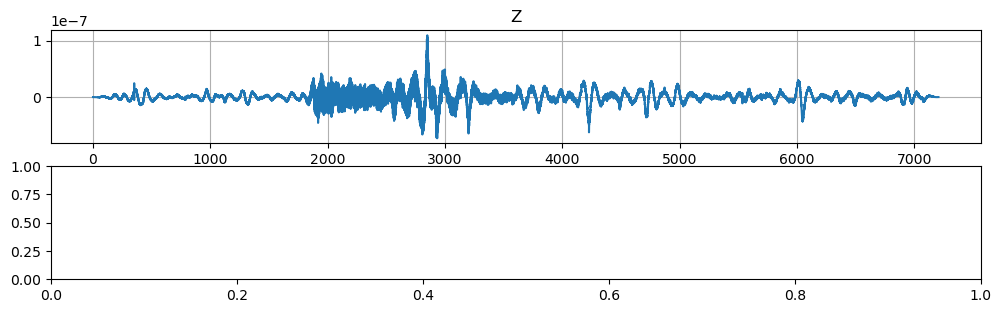

In [3]:
from obspy import UTCDateTime

# Reload data from SAC files
st_z = read(os.path.join(datadir, f"{evname}_{dtype}_BHZ.SAC"))[0]
st_r = read(os.path.join(datadir, f"{evname}_{dtype}_BHR.SAC"))[0]
st_t = read(os.path.join(datadir, f"{evname}_{dtype}_BHT.SAC"))[0]
t = st_z.times()

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(3, 1, 1)
plt.plot(t, st_z.data)
plt.title("Z")
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t, tr_r)
plt.title("R")
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t, tr_t)
plt.title("T")
plt.xlabel("Time (s)")
plt.grid()

print(st_z.stats.starttime)
print(st_z.stats.endtime)

#### Other types of data

##### UVW MSEED

In [119]:
import os
from obspy import read
from obspy.signal.rotate import rotate_ne_rt, rotate2zne
import matplotlib.pyplot as plt

# === Parameters ===
# filedir = "H:\My Drive\Research\SharpSSPy"
filedir = "/Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/SharpSSPy"

evname = "S1102a"
dtype = "VEL"
pzfilter = True

datadir = os.path.join(filedir, "misc", evname)

# # === Load the 3 components ===
# st_u = read(os.path.join(datadir, f"{evname}_BHU_{dtype}.mseed"))[0]
# st_v = read(os.path.join(datadir, f"{evname}_BHV_{dtype}.mseed"))[0]
# st_w = read(os.path.join(datadir, f"{evname}_BHW_{dtype}.mseed"))[0]

# === Load the 3 components ===
st_u = read(os.path.join(datadir, f"{evname}.XB.ELYDG.00.BHU.D.2022.002.{dtype}"))[0]
st_v = read(os.path.join(datadir, f"{evname}.XB.ELYDG.00.BHV.D.2022.002.{dtype}"))[0]
st_w = read(os.path.join(datadir, f"{evname}.XB.ELYDG.00.BHW.D.2022.002.{dtype}"))[0]

In [120]:

# === BAZ ===
# S0976a: 101.8; S1000a: 34.2; S1094b: 44.0; S1102a: 286.0
baz = 286.0

# === Metadata checks ===
assert st_u.stats.delta == st_v.stats.delta == st_w.stats.delta, "Sampling rates differ"
assert len(st_u.data) == len(st_v.data) == len(st_w.data), "Trace lengths differ"

# === Rotate to ZNE ===
azs = (135.1, 15.0, 255.0)
dips = (-29.4, -29.2, -29.7)
tr_z, tr_n, tr_e = rotate2zne(st_u, azs[0], dips[0], st_v, azs[1], dips[1], st_w, azs[2], dips[2])

##### Dahmen data

In [121]:
import os
from obspy import read
from obspy.signal.rotate import rotate_ne_rt, rotate2zne
import matplotlib.pyplot as plt

# === Parameters ===
# filedir = "H:\My Drive\Research\MarsData\Dahmen_deglitched_data\waveforms"
datadir = "/Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/MarsData/Dahmen_deglitched_data/waveforms"

# filedir = "H:\My Drive\Research\SharpSSPy"
filedir = "/Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/SharpSSPy"

evname = "S1102a"
dtype = "VEL"
baz = 87.3

output_dir = os.path.join(filedir, "misc", evname+'_Dahmen')
os.makedirs(output_dir, exist_ok=True)

# === Load the 3 components ===
st = read(os.path.join(datadir, evname))

tr_z = st.select(component='Z')[0].data
tr_n = st.select(component='N')[0].data
tr_e = st.select(component='E')[0].data

##### Rotate ZNE-ZRT and plot

In [21]:

# === Rotate to RT ===
tr_r, tr_t = rotate_ne_rt(tr_n, tr_e, baz)

# === Create rotated traces ===
tr_z_obj, tr_n_obj, tr_e_obj, tr_r_obj, tr_t_obj = [st[0].copy() for _ in range(5)]

tr_z_obj.data = tr_z
tr_n_obj.data = tr_n
tr_e_obj.data = tr_e
tr_r_obj.data = tr_r
tr_t_obj.data = tr_t

tr_z_obj.stats.channel = "BHZ"
tr_n_obj.stats.channel = "BHN"
tr_e_obj.stats.channel = "BHE"
tr_r_obj.stats.channel = "BHR"
tr_t_obj.stats.channel = "BHT"

# === Save rotated components ===
# output_dir = datadir  # Save in same directory
tr_z_obj.write(os.path.join(output_dir, f"{evname}_{dtype}_BHZ.SAC"), format="SAC")
tr_n_obj.write(os.path.join(output_dir, f"{evname}_{dtype}_BHN.SAC"), format="SAC")
tr_e_obj.write(os.path.join(output_dir, f"{evname}_{dtype}_BHE.SAC"), format="SAC")
tr_r_obj.write(os.path.join(output_dir, f"{evname}_{dtype}_BHR.SAC"), format="SAC")
tr_t_obj.write(os.path.join(output_dir, f"{evname}_{dtype}_BHT.SAC"), format="SAC")

# === Bandpass for plotting ===#
fmin, fmax = 0.3, 0.8
tr_z_obj.taper(max_percentage=0.03).filter("bandpass", freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)
tr_r_obj.taper(max_percentage=0.03).filter("bandpass", freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)
tr_t_obj.taper(max_percentage=0.03).filter("bandpass", freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)

# === Plotting ===
t = tr_z_obj.times()

plt.figure(figsize=(12, 10))

# --- After Rotation: Z, R, T ---
plt.subplot(3, 1, 1)
plt.plot(t, tr_z_obj, color="black")
plt.title("BHZ (Vertical)")
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t, tr_r_obj, color="green")
plt.title("BHR (Radial)")
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t, tr_t_obj, color="orange")
plt.title("BHT (Transverse)")
plt.xlabel("Time (s)")
plt.grid()

plt.tight_layout()
plt.show()

print(tr_z_obj.stats.starttime)
print(tr_z_obj.stats.endtime)

NameError: name 'tr_n' is not defined

### Bandpass and zoom in on PP and SS

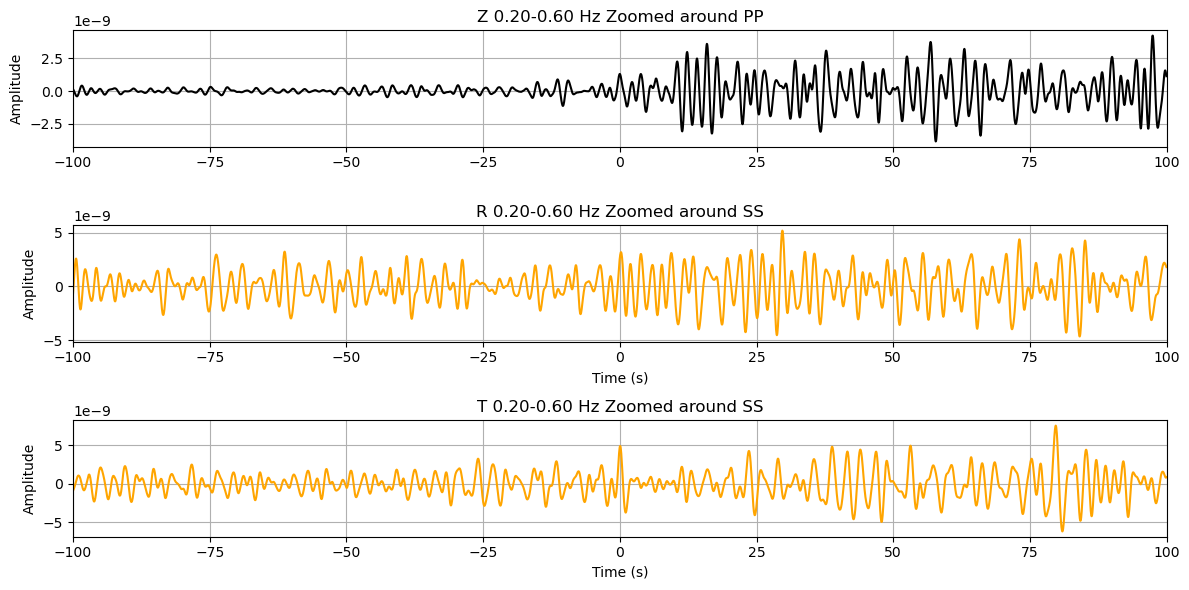

Saved cut SAC files to /Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/SharpSSPy/misc/S1000a/cut


In [7]:
from obspy import read, UTCDateTime
import matplotlib.pyplot as plt

# Define parameters
reload = True
PPfreq = (0.2, 0.6)
SSfreq = (0.2, 0.6)
cutwin = (-100, 100) # for plotting only, does not trim data

# PP and SS arrival time
# S1000a
PP_arrival_time = UTCDateTime("2021-09-18T18:01:48.4") # MQS: 2021-09-18T18:01:47
SS_arrival_time = UTCDateTime("2021-09-18T18:14:04.5") # MQS: 2021-09-18T18:14:08
# # S0976a
# PP_arrival_time = UTCDateTime("2021-08-25T03:49:13")
# SS_arrival_time = UTCDateTime("2021-08-25T04:03:16")
# # S1094b
# PP_arrival_time = UTCDateTime("2021-12-24T22:45:08")+25
# SS_arrival_time = UTCDateTime("2021-12-24T22:45:08")+404

first_arrival_time = PP_arrival_time # This will determine the noise window
noise_end_time = first_arrival_time - 30

# Load rotated traces
if reload:
    st_z = read(os.path.join(datadir, f"{evname}_{dtype}_BHZ.SAC"))[0]
    st_r = read(os.path.join(datadir, f"{evname}_{dtype}_BHR.SAC"))[0]
    st_t = read(os.path.join(datadir, f"{evname}_{dtype}_BHT.SAC"))[0]

# Get trace start time
start_time = st_z.stats.starttime

# Apply bandpass filter (e.g., 0.02–0.2 Hz)
st_z_filtered = st_z.copy().filter("bandpass", freqmin=PPfreq[0], freqmax=PPfreq[1], corners=2, zerophase=True)
st_r_filtered = st_r.copy().filter("bandpass", freqmin=SSfreq[0], freqmax=SSfreq[1], corners=2, zerophase=True)
st_t_filtered = st_t.copy().filter("bandpass", freqmin=SSfreq[0], freqmax=SSfreq[1], corners=2, zerophase=True)

# Zoom windows
z_time_center = PP_arrival_time - start_time
t_time_center = SS_arrival_time - start_time

# Time arrays
t_z = st_z_filtered.times()
t_r = st_r_filtered.times()
t_t = st_t_filtered.times()

# Indices for zooming
idx_z = (t_z >= z_time_center + cutwin[0]) & (t_z <= z_time_center + cutwin[1])
idx_r = (t_r >= t_time_center + cutwin[0]) & (t_r <= t_time_center + cutwin[1])
idx_t = (t_t >= t_time_center + cutwin[0]) & (t_t <= t_time_center + cutwin[1])

# Plot
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(t_z[idx_z]-z_time_center, st_z_filtered.data[idx_z], color='black')
plt.xlim(cutwin)
plt.title(f"Z {PPfreq[0]:.2f}-{PPfreq[1]:.2f} Hz Zoomed around PP")
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t_r[idx_t]-t_time_center, st_r_filtered.data[idx_r], color='orange')
plt.xlim(cutwin)
plt.title(f"R {SSfreq[0]:.2f}-{SSfreq[1]:.2f} Hz Zoomed around SS")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t_t[idx_t]-t_time_center, st_t_filtered.data[idx_t], color='orange')
plt.xlim(cutwin)
plt.title(f"T {SSfreq[0]:.2f}-{SSfreq[1]:.2f} Hz Zoomed around SS")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()

plt.tight_layout()
plt.show()

# Save to SAC
from obspy import Stream

# --- Cut and save traces ---
# Z component (around PP)
start_PP = PP_arrival_time + cutwin[0]
end_PP   = PP_arrival_time + cutwin[1]
st_z_cut = st_z_filtered.copy().trim(starttime=start_PP, endtime=end_PP)

# R and T components (around SS)
start_SS = SS_arrival_time + cutwin[0]
end_SS   = SS_arrival_time + cutwin[1]
st_r_cut = st_r_filtered.copy().trim(starttime=start_SS, endtime=end_SS)
st_t_cut = st_t_filtered.copy().trim(starttime=start_SS, endtime=end_SS)

# Put into one stream for convenience
st_cut = Stream(traces=[st_z_cut, st_r_cut, st_t_cut])

# Save each as SAC
outdir = os.path.join(datadir, "cut")
os.makedirs(outdir, exist_ok=True)

st_z_cut.write(os.path.join(outdir, f"{evname}_{dtype}_BHZ_PP.SAC"), format="SAC")
st_r_cut.write(os.path.join(outdir, f"{evname}_{dtype}_BHR_SS.SAC"), format="SAC")
st_t_cut.write(os.path.join(outdir, f"{evname}_{dtype}_BHT_SS.SAC"), format="SAC")

print(f"Saved cut SAC files to {outdir}")

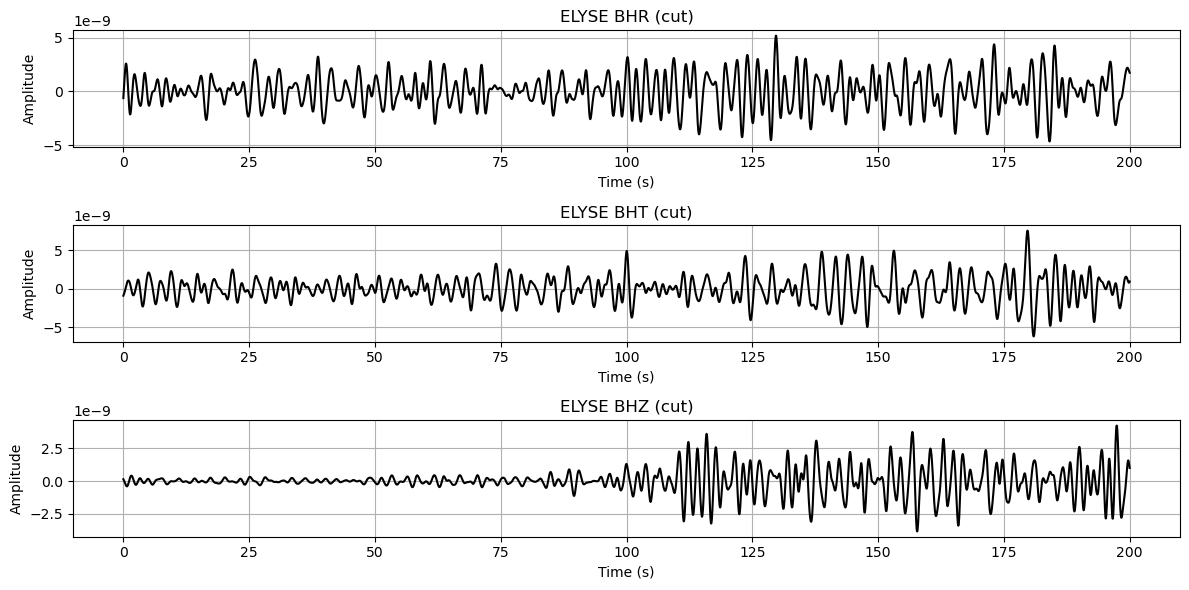

In [8]:
from obspy import read
import matplotlib.pyplot as plt

# Load the cut SAC files
st_check = read(os.path.join(outdir, f"{evname}_{dtype}_BH*.SAC"))

plt.figure(figsize=(12, 6))
for i, tr in enumerate(st_check):
    t = tr.times()
    plt.subplot(3, 1, i+1)
    plt.plot(t, tr.data, color="black")
    plt.title(f"{tr.stats.station} {tr.stats.channel} (cut)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid()

plt.tight_layout()
plt.show()


### Using polarization filtering: Look at data after pzfilter

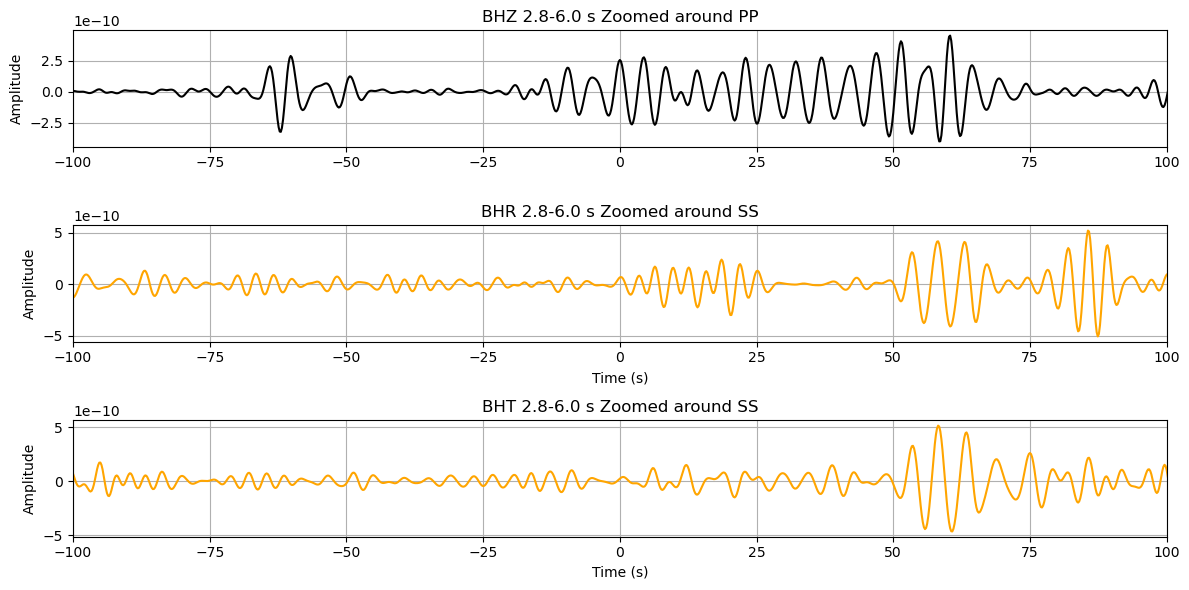

In [41]:
from obspy import read, UTCDateTime
import matplotlib.pyplot as plt

# Define parameters
reload = True
fmin = 1/6
fmax = 1/2.8
xlim  = (-100, 100)

# PP and SS arrival time
# # S1000a
# PP_arrival_time = UTCDateTime("2021-09-18T18:01:47")
# SS_arrival_time = UTCDateTime("2021-09-18T18:14:08")
# S0976a
PP_arrival_time = UTCDateTime("2021-08-25T03:49:06")
SS_arrival_time = UTCDateTime("2021-08-25T04:03:07")

# Load rotated traces
st_z = read(os.path.join(datadir, f"{evname}_{dtype}_PP_pzfiltered_BHZ.SAC"))[0]
st_r = read(os.path.join(datadir, f"{evname}_{dtype}_SS_pzfiltered_BHR.SAC"))[0]
st_t = read(os.path.join(datadir, f"{evname}_{dtype}_SS_pzfiltered_BHT.SAC"))[0]

# Apply bandpass filter (e.g., 0.02–0.2 Hz)
st_z_filtered = st_z.copy().filter("bandpass", freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)
st_r_filtered = st_r.copy().filter("bandpass", freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)
st_t_filtered = st_t.copy().filter("bandpass", freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)

# Time arrays
t_z = st_z_filtered.times()
t_r = st_r_filtered.times()
t_t = st_t_filtered.times()

# Plot
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(t_z-120, st_z_filtered.data, color='black')
plt.xlim(xlim)
plt.title(f"BHZ {1/fmax}-{1/fmin} s Zoomed around PP")
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t_r-120, st_r_filtered.data, color='orange')
plt.xlim(xlim)
plt.title(f"BHR {1/fmax}-{1/fmin} s Zoomed around SS")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t_t-120, st_t_filtered.data, color='orange')
plt.xlim(xlim)
plt.title(f"BHT {1/fmax}-{1/fmin} s Zoomed around SS")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()

plt.tight_layout()
plt.show()

### Getting the reference wavelets

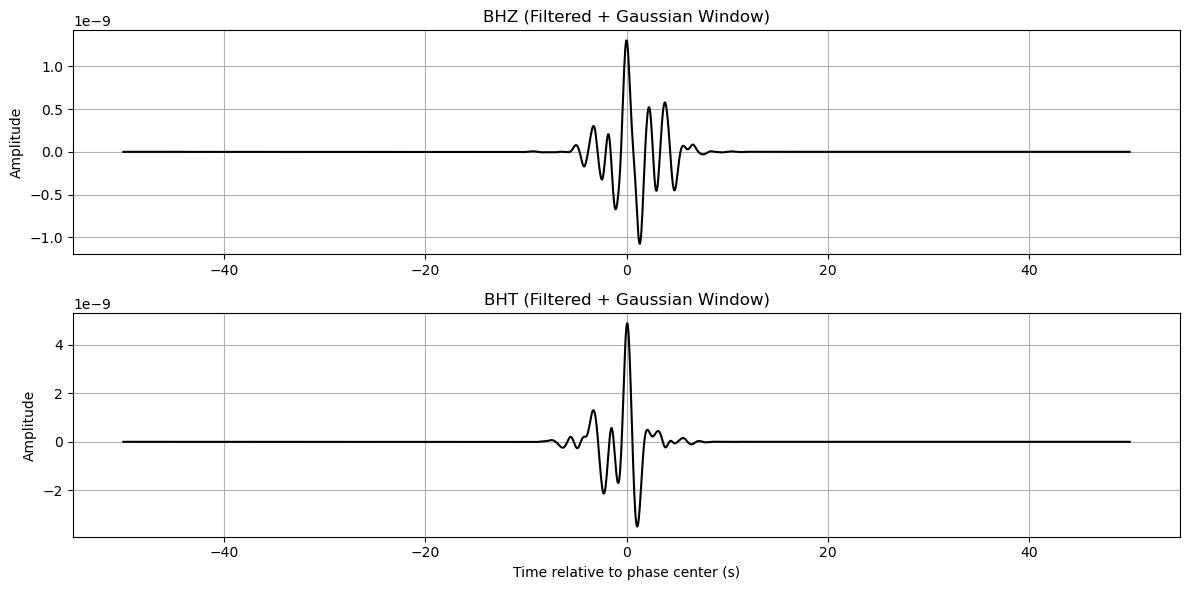

In [23]:
import numpy as np
# --- Apply Gaussian Window ---

# Zoomed times relative to center
t_zoom_z = t_z[idx_z] - z_time_center
t_zoom_t = t_t[idx_t] - t_time_center

# Gaussian window (sigma = 6 s)
sigma = 3.0
gaussian_window_z = np.exp(-0.5 * (t_zoom_z / sigma)**2)
gaussian_window_t = np.exp(-0.5 * (t_zoom_t / sigma)**2)

# Apply window to seismograms
z_filtered_windowed = st_z_filtered.data[idx_z] * gaussian_window_z
t_filtered_windowed = st_t_filtered.data[idx_t] * gaussian_window_t

# Plot windowed waveforms
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t_zoom_z, z_filtered_windowed, color='black')
plt.title("BHZ (Filtered + Gaussian Window)")
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t_zoom_t, t_filtered_windowed, color='black')
plt.title("BHT (Filtered + Gaussian Window)")
plt.xlabel("Time relative to phase center (s)")
plt.ylabel("Amplitude")
plt.grid()

plt.tight_layout()
plt.show()


### Save data

In [ ]:
# Save name
save_suffix = "_src3s"

# Define cut window (in seconds)
# This will TRIM the data
cut_b, cut_a = -40, 40
cut_len = cut_a - cut_b

# Time vector centered at zero
time = np.arange(cut_b, cut_a, st_z_filtered.stats.delta)
npts_cut = len(time)

# Cut D: filtered data centered around phase arrival
idx_cut_z = (t_z >= z_time_center + cut_b) & (t_z < z_time_center + cut_a)
idx_cut_t = (t_t >= t_time_center + cut_b) & (t_t < t_time_center + cut_a)

D_z = st_z_filtered.data[idx_cut_z]
D_t = st_t_filtered.data[idx_cut_t]

# Ensure correct length for D
if len(D_z) != npts_cut:
    D_z = np.pad(D_z, (0, npts_cut - len(D_z)))
if len(D_t) != npts_cut:
    D_t = np.pad(D_t, (0, npts_cut - len(D_t)))

# Cut P
idx_cut_z = (t_zoom_z >= cut_b) & (t_zoom_z < cut_a)
idx_cut_t = (t_zoom_t >= cut_b) & (t_zoom_t < cut_a)
P_z = z_filtered_windowed[idx_cut_z]
P_t = t_filtered_windowed[idx_cut_t]

# # Pad P to match full cut length
# pad_left_z = np.sum(time < t_zoom_z[0])
# pad_right_z = npts_cut - len(z_filtered_windowed) - pad_left_z
# P_z = np.pad(z_filtered_windowed, (pad_left_z, pad_right_z))

# pad_left_t = np.sum(time < t_zoom_t[0])
# pad_right_t = npts_cut - len(t_filtered_windowed) - pad_left_t
# P_t = np.pad(t_filtered_windowed, (pad_left_t, pad_right_t))

# Normalize
norm_z = max(np.abs(P_z))
P_z = P_z / norm_z
D_z = D_z / norm_z
norm_t = max(np.abs(P_t))
P_t = P_t / norm_t
D_t = D_t / norm_t

# Cut noise
noise_start_time = 0
noise_end_time = noise_end_time - start_time

idx_noise = (t_z >= noise_start_time) & (t_z < noise_end_time)

noise_z = st_z_filtered[idx_noise]
noise_t = st_t_filtered[idx_noise]

# Normalize noise
noise_z /= norm_z
noise_t /= norm_t

# Define output dirs
outdir_PP = os.path.join(filedir, "data", evname + save_suffix + "_PP")
outdir_SS = os.path.join(filedir, "data", evname + save_suffix + "_SS")

# Make directories if they don't exist
os.makedirs(outdir_PP, exist_ok=True)
os.makedirs(outdir_SS, exist_ok=True)

# Save .npz files
np.savez(os.path.join(outdir_PP, "data.npz"), P=P_z, D=D_z, noise=noise_z, time=time)
np.savez(os.path.join(outdir_SS, "data.npz"), P=P_t, D=D_t, noise=noise_t, time=time)

# dt = time[1] - time[0]
# prior = Prior(tlen=time[-1], stdP=0.1, dt=dt, widRange=(0.1, 2), ampRange=(-0.3, 0.), negOnly=True, align=3., maxN=2)
# # Save prior
# with open("./S0976a_PP/prior.pkl", "wb") as f:
#     pickle.dump(prior, f)
# with open("./S0976a_SS/prior.pkl", "wb") as f:
#     pickle.dump(prior, f)
# with open("./S0976a_PP_SS/prior.pkl", "wb") as f:
#     pickle.dump(prior, f)

#### Plot to confirm: P and D

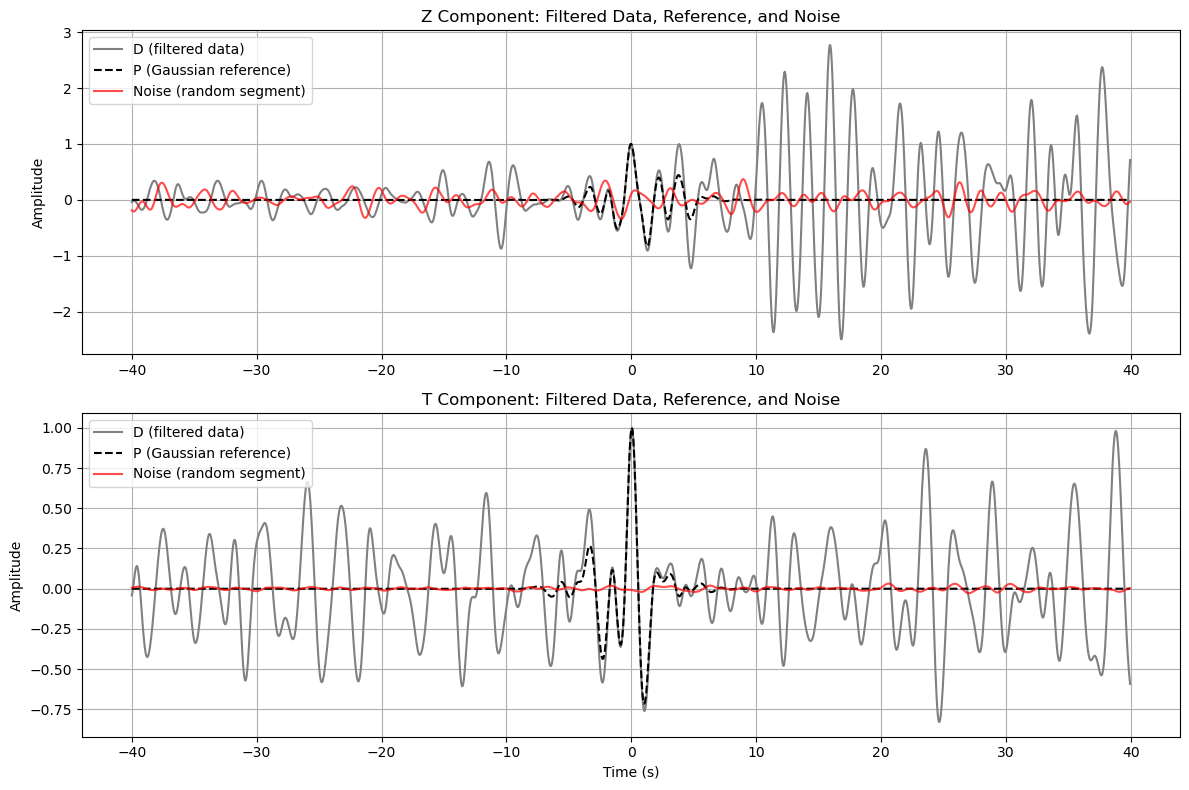

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# --- Load saved PP and SS data with noise ---
data_Z = np.load(os.path.join(outdir_PP, "data.npz"))
data_T = np.load(os.path.join(outdir_SS, "data.npz"))

# Extract
time   = data_Z["time"]
P_z, D_z, noise_z = data_Z["P"], data_Z["D"], data_Z["noise"]
P_t, D_t, noise_t = data_T["P"], data_T["D"], data_T["noise"]

import numpy as np
import matplotlib.pyplot as plt

# --- Select random noise segment ---
def random_noise_segment(noise_full, segment_len):
    n_total = len(noise_full)
    if segment_len > n_total:
        raise ValueError("Segment length is longer than noise trace")
    start_idx = np.random.randint(0, n_total - segment_len + 1)
    return noise_full[start_idx:start_idx + segment_len]

# Select segments
noise_z_segment = random_noise_segment(noise_z, len(time))
noise_t_segment = random_noise_segment(noise_t, len(time))

# --- Plot ---
plt.figure(figsize=(12, 8))

# Z component
plt.subplot(2, 1, 1)
plt.plot(time, D_z, label="D (filtered data)", color="gray")
plt.plot(time, P_z, label="P (Gaussian reference)", color="black", linestyle="--")
plt.plot(time, noise_z_segment, label="Noise (random segment)", color="red", alpha=0.7)
plt.title("Z Component: Filtered Data, Reference, and Noise")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()

# T component
plt.subplot(2, 1, 2)
plt.plot(time, D_t, label="D (filtered data)", color="gray")
plt.plot(time, P_t, label="P (Gaussian reference)", color="black", linestyle="--")
plt.plot(time, noise_t_segment, label="Noise (random segment)", color="red", alpha=0.7)
plt.title("T Component: Filtered Data, Reference, and Noise")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


### CD_fit

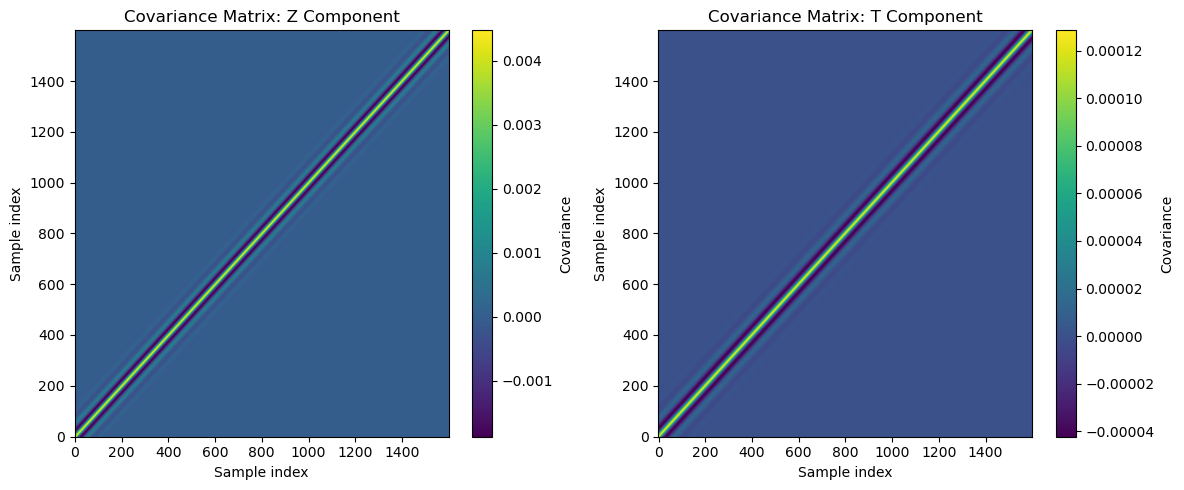

In [26]:
from scipy.signal import correlate
from scipy.linalg import toeplitz
from scipy.optimize import curve_fit
import numpy as np
import os

def build_noise_covariance(noise, dt, desired_length, max_lag_seconds=50, comp="Z", output_dir="."):
    """
    Build covariance matrix from a single (possibly long) noise trace using
    Kolb & Lekic (2014) parameterization, but output a covariance matrix
    of a specified desired length.
    
    Parameters:
        noise : ndarray
            Noise trace (1D, can be longer than desired length)
        dt : float
            Sampling interval (s)
        desired_length : int
            Number of points for the output covariance matrix
        max_lag_seconds : float
            Maximum lag for fitting the autocovariance
        comp : str
            Component name (for saving file)
        output_dir : str
            Directory to save the covariance matrix
    Returns:
        CD_fit : ndarray
            Desired_length x desired_length covariance matrix
    """
    n_samples = len(noise)
    max_lag = int(max_lag_seconds / dt)

    # Zero mean
    noise = noise - np.mean(noise)

    # Autocorrelation (non-negative lags only)
    acorr = correlate(noise, noise, mode="full")
    acorr = acorr[n_samples - 1:]      # keep non-negative lags
    acorr = acorr[:max_lag]            # truncate at max lag
    acorr /= n_samples                 # normalize

    # Time lags for fitting
    lags = np.arange(len(acorr)) * dt

    # Normalize for stable fitting
    acorr_norm = acorr / acorr[0]

    # Model: a * exp(-λτ) * cos(λω₀τ)
    def model(tau, a, lambd, omega0):
        return a * np.exp(-lambd * tau) * np.cos(lambd * omega0 * tau)

    try:
        popt, _ = curve_fit(
            model,
            lags,
            acorr_norm,
            p0=(1.0, 0.1, 2 * np.pi * 0.2),
            maxfev=10000
        )
        a_fit_norm, lambda_fit, omega0_fit = popt
        a_fit = a_fit_norm * acorr[0]  # rescale amplitude
    except RuntimeError as e:
        print(f"[WARN] Fit failed for {comp}: {e}")
        return None

    # Generate full autocovariance for desired length
    full_lags = np.arange(desired_length) * dt
    acov_fit = a_fit * np.exp(-lambda_fit * full_lags) * np.cos(lambda_fit * omega0_fit * full_lags)

    # Toeplitz covariance matrix
    CD_fit = toeplitz(acov_fit)

    # Save
    os.makedirs(output_dir, exist_ok=True)
    np.savetxt(os.path.join(output_dir, "CD.csv"), CD_fit, delimiter=",")

    return CD_fit


dt = st_z.stats.delta
desired_len = len(time)  # length of your data/reference
CD_z = build_noise_covariance(noise_z, dt, desired_length=desired_len, comp="Z", output_dir=outdir_PP)
CD_t = build_noise_covariance(noise_t, dt, desired_length=desired_len, comp="T", output_dir=outdir_SS)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Z component
plt.subplot(1, 2, 1)
plt.imshow(CD_z, origin="lower", cmap="viridis", aspect="auto")
plt.colorbar(label="Covariance")
plt.title("Covariance Matrix: Z Component")
plt.xlabel("Sample index")
plt.ylabel("Sample index")

# T component
plt.subplot(1, 2, 2)
plt.imshow(CD_t, origin="lower", cmap="viridis", aspect="auto")
plt.colorbar(label="Covariance")
plt.title("Covariance Matrix: T Component")
plt.xlabel("Sample index")
plt.ylabel("Sample index")

plt.tight_layout()
plt.show()


### Data check: Spectrogram

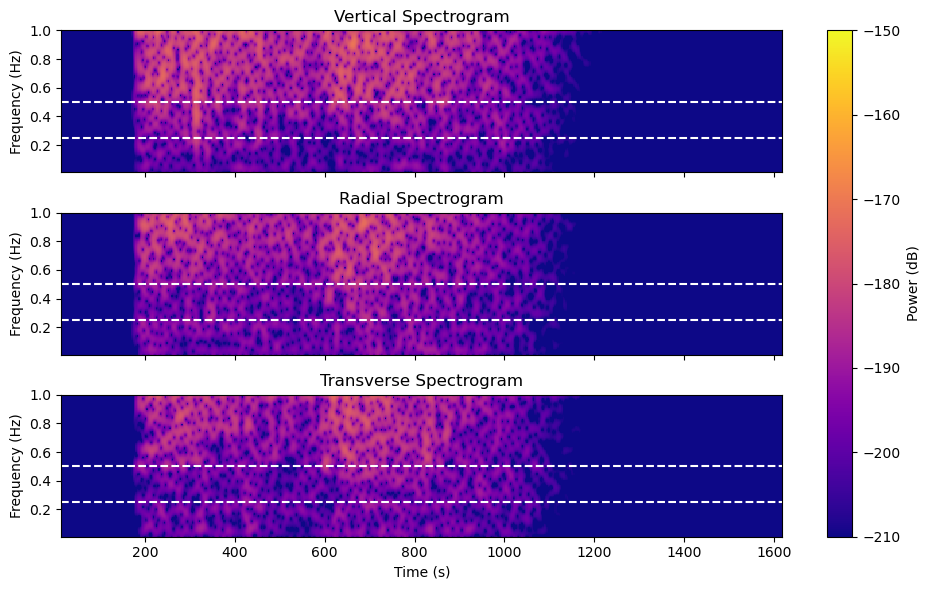

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from obspy import read
import matplotlib.mlab as mlab
from obspy.signal.util import next_pow_2

# Parameters
winlen_sec = 30.0
overlap = 0.9
cmap = 'plasma'
vmin = -210  # dB
vmax = -150  # dB

def calc_spectrogram(trace, winlen_sec, overlap):
    winlen = int(winlen_sec * trace.stats.sampling_rate)
    noverlap = int(winlen * overlap)
    p, f, t = mlab.specgram(trace.data, NFFT=winlen, Fs=trace.stats.sampling_rate,
                            noverlap=noverlap, pad_to=next_pow_2(winlen) * 4)
    return p, f, t

# Load rotated traces
st_z = read(os.path.join(output_dir, f"{evname}_{dtype}_BHZ.SAC"))[0]
st_r = read(os.path.join(output_dir, f"{evname}_{dtype}_BHR.SAC"))[0]
st_t = read(os.path.join(output_dir, f"{evname}_{dtype}_BHT.SAC"))[0]

# Plot spectrograms
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

for tr, ax, label in zip([st_z, st_r, st_t], axes, ['Vertical', 'Radial', 'Transverse']):
    p, f, t = calc_spectrogram(tr, winlen_sec, overlap)
    im = ax.pcolormesh(t, f, 10. * np.log10(p), cmap=cmap, vmin=vmin, vmax=vmax)
    # ax.set_yscale('log')
    ax.set_ylim(0.01, 1.0)
    ax.set_ylabel("Frequency (Hz)")
    ax.set_title(f"{label} Spectrogram")
    ax.axhline(fmin, color='w', linestyle='--', linewidth=1.5)
    ax.axhline(fmax, color='w', linestyle='--', linewidth=1.5)
    # if label == 'Vertical': ax.axvline(z_time_center, color='w', linestyle='--', linewidth=1.5) # PP Horleston: S0976a-2797.644
    # if label == 'Radial': ax.axvline(t_time_center, color='w', linestyle='--', linewidth=1.5) # SS Horleston: S0976a-3658.644
    # if label == 'Transverse': ax.axvline(t_time_center, color='w', linestyle='--', linewidth=1.5) # SS Horleston: S0976a-3658.644

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.colorbar(im, ax=axes, label="Power (dB)")
# plt.savefig("S0976a_rotated_spectrograms.png", dpi=300)
plt.show()


In [2]:
from obspy.taup.taup_create import build_taup_model
import os

# moddir = "H:\My Drive\Research\MarsData\models_Mars"
moddir = "/Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/MarsData/models_Mars"
modname = 'InSight_KKS21'

build_taup_model(os.path.join(moddir, modname+'.nd'), output_folder=moddir+'/npz_files/')

Building obspy.taup model for '/Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/MarsData/models_Mars/InSight_KKS21.nd' ...
filename = /Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/MarsData/models_Mars/InSight_KKS21.nd
Done reading velocity model.
Radius of model . is 3389.5
Using parameters provided in TauP_config.ini (or defaults if not) to call SlownessModel...
Parameters are:
taup.create.min_delta_p = 0.1 sec / radian
taup.create.max_delta_p = 11.0 sec / radian
taup.create.max_depth_interval = 115.0 kilometers
taup.create.max_range_interval = 0.04363323129985824 degrees
taup.create.max_interp_error = 0.05 seconds
taup.create.allow_inner_core_s = True
Slow model  465 P layers,428 S layers
Done calculating Tau branches.
Done Saving /Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/MarsData/models_Mars/npz_files/InSight_KKS21.npz
Method run is done, but not necessarily successful.


In [109]:
from obspy.taup.taup_create import build_taup_model
import os

# moddir = "H:\My Drive\Research\MarsData\models_Mars"
moddir = "/Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/MarsData/models_Mars"
modname = 'Duran_Model_SWmod_1000a'

build_taup_model(os.path.join(moddir, modname+'.nd'), output_folder=moddir+'/npz_files/')

Building obspy.taup model for '/Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/MarsData/models_Mars/Duran_Model_SWmod_1000a.nd' ...
filename = /Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/MarsData/models_Mars/Duran_Model_SWmod_1000a.nd
Done reading velocity model.
Radius of model . is 3389.5
Using parameters provided in TauP_config.ini (or defaults if not) to call SlownessModel...
Parameters are:
taup.create.min_delta_p = 0.1 sec / radian
taup.create.max_delta_p = 11.0 sec / radian
taup.create.max_depth_interval = 115.0 kilometers
taup.create.max_range_interval = 0.04363323129985824 degrees
taup.create.max_interp_error = 0.05 seconds
taup.create.allow_inner_core_s = True
Slow model  1440 P layers,1123 S layers
Done calculating Tau branches.
Done Saving /Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/MarsData/models_Mars/npz_files/Duran_Model_SWmod_1000a.npz
Method run is done, but not necessarily successful.


Arrivals (earliest):

PP     time: 922.42 s  ray param: 5.8184 s/deg
SS     time: 1679.75 s  ray param: 11.2895 s/deg
Arrivals (all):

PP     time: 922.42 s  ray param: 5.8184 s/deg
SS     time: 1679.75 s  ray param: 11.2895 s/deg


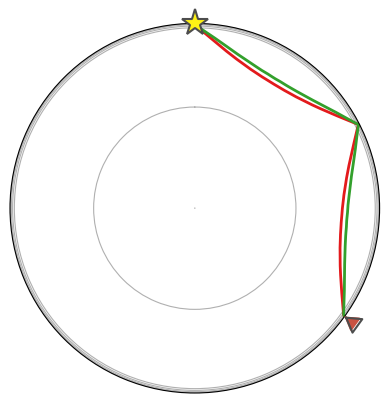

2 arrivals
	PP phase arrival at 922.418 seconds
	SS phase arrival at 1679.746 seconds


In [38]:
import numpy as np
from obspy.taup import TauPyModel

# moddir = "H:\My Drive\Research\MarsData\models_Mars"
moddir = "/Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/MarsData/models_Mars"

# modname = 'Duran_Model_SWmod_1094b'
modname = 'InSight_KKS21'
model = TauPyModel(moddir+'/npz_files/'+modname+'.npz')

# Define source depth (km) and distance (degrees)
depth = 0.  # source depth in km
distance = 125.9  # source-receiver distance in degrees

# Optional: list of phases to compute
# phases = ["P", "PP", "P^mP", "P^9P","P^24P","PPP"]
# phases = ["S", "SS", "S^mS", "S^9S","S^24S","SSS"]
# phases = ["S", "SS", "SSS", "ScS"]
phases = ["PP","SS","PcP","ScS"]

# Get arrivals
arrivals = model.get_travel_times(
    source_depth_in_km=depth,
    distance_in_degree=distance,
    phase_list=phases
)

# Keep only the first arrival per phase name
first_arrivals = {}
for arr in arrivals:
    phase = arr.name
    if phase not in first_arrivals:
        first_arrivals[phase] = arr

# Print results (earliest ones)
print("Arrivals (earliest):\n")
for phase, arr in first_arrivals.items():
    print(f"{arr.name:<6} time: {arr.time:6.2f} s  ray param: {arr.ray_param * (np.pi/180):.4f} s/deg")

# Print results (all)
print("Arrivals (all):\n")
for arr in arrivals:
    print(f"{arr.name:<6} time: {arr.time:6.2f} s  ray param: {arr.ray_param * (np.pi/180):.4f} s/deg")

# Get ray paths
rps = model.get_ray_paths(
    source_depth_in_km=depth,
    distance_in_degree=distance,
    phase_list=phases
)

rps.plot_rays()#(plot_type="cartesian")
print(rps)

In [108]:
import os
import numpy as np

# === paths ===
# moddir = "H:\My Drive\Research\MarsData\models_Mars"
moddir = "/Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/MarsData/models_Mars/SW_models"
modname = 'K1000aR1.dat'
infile = os.path.join(moddir, modname)        # <-- change this
outfile = "K1000aR1_shallow.nd"     # output .nd

# === load: col0=Vs (km/s), col1=Depth (km), col2=Posterior ===
data = np.loadtxt(infile)
vs_all   = data[:, 0].astype(float)
depth_in = data[:, 1].astype(float)
post_all = data[:, 2].astype(float)

# === depth grid (0..90 km every 0.5 km) ===
step = 0.5
depths = np.arange(0.0, 90.0 + step/2, step)

# snap input depths to grid (robust to tiny FP jitter)
depth_snap = np.round(depth_in / step) * step
depth_snap = np.round(depth_snap, 3)

# pick Vs with the largest posterior at each depth
vs_profile = []
for d in depths:
    mask = np.isclose(depth_snap, d)
    if not np.any(mask):
        raise ValueError(f"No rows found for depth {d} km in {infile}")
    best_vs = vs_all[mask][np.argmax(post_all[mask])]
    vs_profile.append(best_vs)

vs_profile = np.array(vs_profile)

# === fake Vp and rho ===
vp  = 1.7 * vs_profile
rho = 2.7 + 0.3 * vs_profile

# === write 4-column TauP .nd: depth  vp  vs  rho (no headers) ===
with open(outfile, "w") as f:
    for d, p, s, r in zip(depths, vp, vs_profile, rho):
        f.write(f"{d:8.3f}  {p:8.5f}  {s:8.5f}  {r:8.5f}\n")

print(f"Wrote {outfile} with {len(depths)} layers (0–90 km, Δ=0.5 km).")


Wrote K1000aR1_shallow.nd with 181 layers (0–90 km, Δ=0.5 km).
